# Analysis on Learned Video Features

In [1]:
%matplotlib inline
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../coco-caption')
import torch
import numpy as np
from tqdm import tqdm
from dataloader import get_loader
from misc.utils import to_device
from models import Model
from config import Constants
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator

init COCO-EVAL scorer


In [2]:
def get_model_and_device(checkpoint_path, device=None, strict=True, new_opt_used_to_override={}, **kwargs):
    if device is None:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
    elif type(device) is str:
        device = torch.device(device)
    else:
        raise ValueError()
    
    model = Model.load_from_checkpoint(
        checkpoint_path, 
        map_location=device,
        strict=strict,
        new_opt_used_to_override=new_opt_used_to_override
    )
    model.eval()
    
    return model, device

In [3]:
def standardize(data: torch.Tensor):
    return (data - data.mean(dim=0, keepdim=True)) / data.std(dim=0, keepdim=True)

def get_video_features_and_category(model, device, do_standardize=True, mean=True):
    opt = model.get_opt()
    assert opt['dataset'] == 'MSRVTT'
    model.eval()
    model.to(device)

    loader = get_loader(opt, 'test', print_info=False, specific=-1, 
                not_shuffle=True, is_validation=True)

    video_features = []
    category = []

    for batch in tqdm(loader):
        with torch.no_grad():
            for k in model.get_keys_to_device(teacher_forcing=True):
                if k in batch:
                    batch[k] = to_device(batch[k], device)

            step_outputs = model.captioner.feedforward_step(batch)
        
        for i, vid in enumerate(batch['video_ids']):
            video_features.append(step_outputs['encoder_hidden_states'][i])
            category.append(batch['category'][i])
    
    video_features = torch.stack(video_features, dim=0) # [n_samples, n_frames * n_modality, dim_hidden]
    if mean:
        video_features = video_features.mean(1) # [n_samples, dim_hidden]
    if do_standardize:
        video_features = standardize(video_features)
    video_features = video_features.cpu().numpy()

    category = torch.stack(category, dim=0).view(-1).cpu().numpy()
    assert video_features.shape[0] == category.shape[0]

    return video_features, category

In [4]:
def get_idx_of_specific_category(category, specific):
    idx = []
    for i, c in enumerate(category):
        if c == specific:
            idx.append(i)
    
    return idx, Constants.index2category[specific]
    
def get_average_cosine_similarity_matrix(embs, category):
    all_dis = np.zeros((20, 20))
    for i in tqdm(range(20)):
        embs1 = embs[get_idx_of_specific_category(category, i)[0]]
        
        for j in range(i, 20):
            embs2 = embs[get_idx_of_specific_category(category, j)[0]]
            this_dis = []
            for e in embs1:
                this_dis.append(torch.cosine_similarity(e.unsqueeze(0), embs2))
            
            this_dis = torch.stack(this_dis).mean().item()
            all_dis[i, j] = all_dis[j, i] = this_dis
        
    return all_dis

In [5]:
INP, device = get_model_and_device(
    checkpoint_path='../exps/MSRVTT/Transformer/diff_feats/R101_ami/best.ckpt',
    device='cpu',
    strict=True
)
INP_vf, category = get_video_features_and_category(INP, device, do_standardize=True, mean=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:23<00:00,  2.01it/s]


In [6]:
CLIP, device = get_model_and_device(
    checkpoint_path='../exps/MSRVTT/Transformer/diff_feats/RN101_ami/best.ckpt',
    device='cpu',
    strict=True
)
CLIP_vf, category = get_video_features_and_category(CLIP, device, do_standardize=True, mean=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:23<00:00,  2.01it/s]


In [7]:
INP_ACS_matrix = get_average_cosine_similarity_matrix(torch.from_numpy(INP_vf), category)
CLIP_ACS_matrix = get_average_cosine_similarity_matrix(torch.from_numpy(CLIP_vf), category)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:21<00:00, 19.10s/it]


In [8]:
mACS_INP = np.diagonal(INP_ACS_matrix).mean()
mACS_CLIP = np.diagonal(CLIP_ACS_matrix).mean()
print((mACS_CLIP - mACS_INP) / mACS_INP)

0.18334447168423343


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


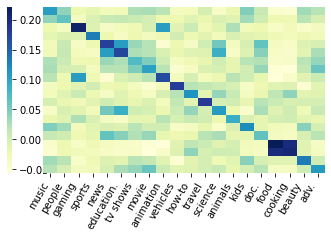

In [9]:
plt.rc('font',family='Times New Roman') 

grid_kws = {'width_ratios': (0.01, 0.6)}
f, (cbar_ax, ax) = plt.subplots(ncols=2, gridspec_kw=grid_kws, figsize=(4.5, 3))

sns.heatmap(CLIP_ACS_matrix, cmap='YlGnBu', cbar_ax=cbar_ax, ax=ax)
ax.set_xticklabels([
    'music',
    'people', 
    'gaming',
    'sports',
    'news',
    'education.',
    'tv shows',
    'movie',
    'animation',
    'vehicles',
    'how-to',
    'travel',
    'science',
    'animals',
    'kids',
    'doc.',
    'food',
    'cooking',
    'beauty',
    'adv.'
], rotation=60, ha='right')

ax.set_yticklabels([])
plt.setp(ax.get_yticklines(),visible=False)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.22, wspace=0.22)
# plt.savefig('ACS_map.png', dpi=300)

/home/yangbang/anaconda3/envs/pl/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator


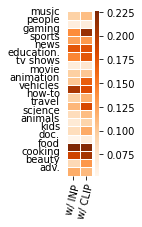

In [10]:
plt.rc('font',family='Times New Roman') 

inp = np.diagonal(INP_ACS_matrix)
clip = np.diagonal(CLIP_ACS_matrix)

grid_kws = {'width_ratios': (0.5, 0.08)}
f, (ax, cbar_ax) = plt.subplots(ncols=2, gridspec_kw=grid_kws, figsize=(1.5, 3))
data = np.concatenate([inp[:, np.newaxis], clip[:, np.newaxis]], axis=1)

sns.heatmap(data, ax=ax, mask=None, linewidths=1, linecolor='white', cmap='Oranges', cbar_ax=cbar_ax)


ax.set_xticklabels([
    'w/ INP', 
    'w/ CLIP'
], rotation=75, ha='center')

ax.yaxis.set_major_locator(MultipleLocator(1))
plt.setp(ax.get_yticklines(),visible=False)

ax.set_yticklabels([
    '',
    'music',
    'people', 
    'gaming',
    'sports',
    'news',
    'education.',
    'tv shows',
    'movie',
    'animation',
    'vehicles',
    'how-to',
    'travel',
    'science',
    'animals',
    'kids',
    'doc.',
    'food',
    'cooking',
    'beauty',
    'adv.'
], rotation=0)

plt.subplots_adjust(left=0.45, right=0.75, top=0.98, bottom=0.22, wspace=0.2)
# plt.savefig('ACS.png', dpi=300)

# Fig 5: An example

In [11]:
from pretreatment.extract_frames_from_videos import extract_frames
from dataloader import get_frame_ids
from misc.utils import get_uniform_items_from_k_snippets
import os
import glob
from torchvision.transforms import Compose, Resize, CenterCrop
from PIL import Image


def extract(vid, all_videos_path = '../../../new_VC_data/MSRVTT/all_videos', add_vid=False):
    video = os.path.join(all_videos_path, vid + '.mp4')
    tmp_path = './dummy'
    if add_vid:
        tmp_path = os.path.join(tmp_path, vid)
    extract_frames(video, tmp_path, 'png', strategy=0)
    frames = sorted(glob.glob(os.path.join(tmp_path, '*.{}'.format('png'))))
    frames = get_uniform_items_from_k_snippets(frames, 60)
    frame_ids = get_frame_ids(len(frames), 28, 'equally_sampling')
    
    original_images, images_basenames = [], []
    for index in frame_ids:
        images_basenames.append(os.path.basename(frames[index]).split('.')[0])
        original_images.append(Image.open(frames[index]).convert('RGB'))

    return original_images, images_basenames, frame_ids


def show(images_to_show, title='', figsize=(15, 6), n_row=4, n_col=7, save_path='', save_name=''):
    fig = plt.figure(figsize=figsize)
    if title:
        plt.title(title)

    for i in range(len(images_to_show)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.imshow(images_to_show[i])
        ax.set_yticks([])
        ax.set_xticks([])

    plt.subplots_adjust(wspace=0, hspace=0.05)
    if save_path:
        assert save_name
        os.makedirs(save_path, exist_ok=True)
        path = os.path.join(save_path, save_name)
        plt.savefig(path, dpi=900)
    plt.show()


def visualize_images(vid, transform=Compose([Resize(224), CenterCrop((224, 224))]), specific_image_positions=[], **kwargs):
    images, *_ = extract(vid)
    if transform is not None:
        for i in range(len(images)):
            images[i] = transform(images[i])
    if len(specific_image_positions):
        new_images = []
        for p in specific_image_positions:
            new_images.append(images[p])
        # images = [image for pos, image in enumerate(images) if pos in specific_image_positions]
        images = new_images
    show(images, **kwargs)

In [12]:
def cal_CS(feats, vid1, vid2):
    id1 = int(vid1[5:]) - 7010
    id2 = int(vid2[5:]) - 7010
    f1 = torch.from_numpy(feats[id1]).unsqueeze(0)
    f2 = torch.from_numpy(feats[id2]).unsqueeze(0)
    print(f'The cosine similarity between {vid1} and {vid2} is', torch.cosine_similarity(f1, f2).item())

In [13]:
anchor = 'video9296'
hard_negative = 'vdieo8993'
hard_positive = 'video7665'
cal_CS(INP_vf, anchor, hard_negative)
cal_CS(INP_vf, anchor, hard_positive)
cal_CS(INP_vf, hard_negative, hard_positive)
print('------')
cal_CS(CLIP_vf, anchor, hard_negative)
cal_CS(CLIP_vf, anchor, hard_positive)
cal_CS(CLIP_vf, hard_negative, hard_positive)

The cosine similarity between video9296 and vdieo8993 is 0.28050947189331055
The cosine similarity between video9296 and video7665 is 0.31067830324172974
The cosine similarity between vdieo8993 and video7665 is -0.011838237755000591
------
The cosine similarity between video9296 and vdieo8993 is -0.021410634741187096
The cosine similarity between video9296 and video7665 is 0.3274385929107666
The cosine similarity between vdieo8993 and video7665 is -0.13130347430706024


 cleanup: ./dummy/


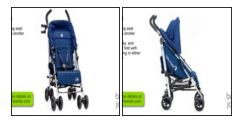

In [14]:
vid = 'video9296'
visualize_images(vid=vid, figsize=(4, 2), specific_image_positions=[2, 16], n_row=1, n_col=2, save_path='./qualitative_figs', save_name='%s.png'%vid)

 cleanup: ./dummy/


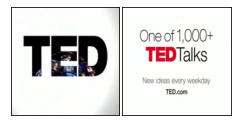

In [15]:
vid = 'video8993'
visualize_images(vid=vid, figsize=(4, 2), specific_image_positions=[5, 27], n_row=1, n_col=2, save_path='./qualitative_figs', save_name='%s.png'%vid)

 cleanup: ./dummy/


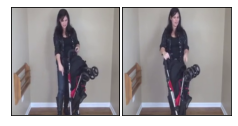

In [16]:
vid = 'video7665'
visualize_images(vid=vid, figsize=(4, 2), specific_image_positions=[3, 18], n_row=1, n_col=2, save_path='./qualitative_figs', save_name='%s.png'%vid)